<a href="https://colab.research.google.com/github/AnoVando/MSIS/blob/master/MSIS549_HW2_CNN_RockPaperScissors_JMatthews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSIS 579 HW2 CNN to recognize Rock/Paper/Scissors

In this homework, we will train a convolution neural network to recognize gesture Rock/Paper/Scissors. 

## Load Rock/Paper/Scissors Dataset
First we download the data and put them into its own directories for model training and evaluation. There are two dataset in zip format. Download each and put them into the corresponding directories.

In [19]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-04-20 20:26:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.28.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.28.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   156MB/s    in 1.2s    

2020-04-20 20:26:35 (156 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-04-20 20:26:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps

In [20]:
%tensorflow_version 1.14
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os
import zipfile
import re
import shutil

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


After running the folloiwng code, you will have exactly 840 images for each gesture. 

In [21]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 1253
total training paper images: 1053
total training scissors images: 1268
['rock07-k03-103.png', 'rock05ck01-075.png', 'rock02-112.png', 'rock02-008.png', 'rock337.png', 'rock221.png', 'rock03-039.png', 'rock01-024.png', 'rock288.png', 'rock02-007.png']
['paper02-026.png', 'paper368.png', 'paper06-054.png', 'paper324.png', 'paper320.png', 'paper406.png', 'paper07-068.png', 'paper04-097.png', 'paper03-051.png', 'paper07-030.png']
['scissors04-009.png', 'testscissors01-001.png', 'scissors289.png', 'scissors02-003.png', 'testscissors02-110.png', 'scissors03-058.png', 'scissors04-033.png', 'testscissors02-111.png', 'scissors03-007.png', 'testscissors01-006.png']


Now, let's plot 2 images from each class.  You wil find those images are taken from different views and images vary a lot even for the same gesture. 

/tmp/rps/rock/rock07-k03-103.png


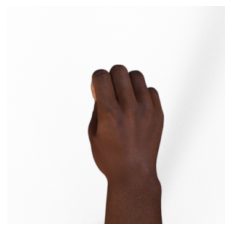

/tmp/rps/rock/rock05ck01-075.png


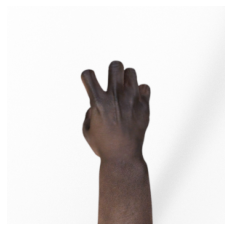

/tmp/rps/paper/paper02-026.png


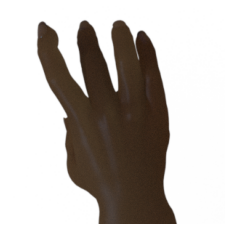

/tmp/rps/paper/paper368.png


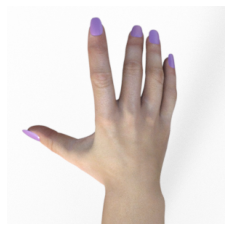

/tmp/rps/scissors/scissors04-009.png


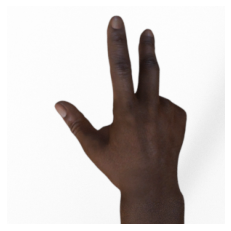

/tmp/rps/scissors/testscissors01-001.png


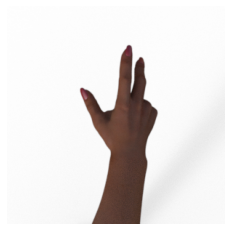

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [0]:
# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/tmp'

# The directory where we will
# store our smaller dataset
base_dir = '/tmp/rock_paper_scissors'
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training paper pictures
train_paper_dir = os.path.join(train_dir, 'paper')
os.mkdir(train_paper_dir)

# Directory with our training rock pictures
train_rock_dir = os.path.join(train_dir, 'rock')
os.mkdir(train_rock_dir)

# Directory with our training scissors pictures
train_scissors_dir = os.path.join(train_dir, 'scissors')
os.mkdir(train_scissors_dir)

# Directory with our validation paper pictures
validation_paper_dir = os.path.join(validation_dir, 'paper')
os.mkdir(validation_paper_dir)

# Directory with our validation rock pictures
validation_rock_dir = os.path.join(validation_dir, 'rock')
os.mkdir(validation_rock_dir)

# Directory with our validation scissors pictures
validation_scissors_dir = os.path.join(validation_dir, 'scissors')
os.mkdir(validation_scissors_dir)

# Directory with our test paper pictures
test_paper_dir = os.path.join(test_dir, 'paper')
os.mkdir(test_paper_dir)

# Directory with our test rock pictures
test_rock_dir = os.path.join(test_dir, 'rock')
os.mkdir(test_rock_dir)

# Directory with our test scissors pictures
test_scissors_dir = os.path.join(test_dir, 'scissors')
os.mkdir(test_scissors_dir)

In [26]:
print(len(os.listdir('/tmp/rps/paper')))

914


In [0]:
os.chdir('/tmp/rps/paper')
i=0
for x in os.listdir('/tmp/rps/paper'):
  src=x
  dst="paper"+str(i)+".png"
  os.rename(src,dst)
  i= i + 1
  if i > 839:
    break

os.chdir('/tmp/rps/rock')
i=0
for x in os.listdir('/tmp/rps/rock'):
  src=x
  dst="rock"+str(i)+".png"
  os.rename(src,dst)
  i= i + 1

os.chdir('/tmp/rps/scissors')
i=0
for x in os.listdir('/tmp/rps/scissors'):
  src=x
  dst="scissors"+str(i)+".png"
  os.rename(src,dst)
  i= i + 1
      

In [27]:
print(len(os.listdir('/tmp/rps/scissors')))

917


In [18]:
# Copy first 420 paper images to train_paper_dir 'paper.{}.jpg'.
fnames = ['paper{}.png'.format(i) for i in range(420)]
for fname in fnames:
  src = os.path.join('/tmp/rps/paper', fname)
  dst = os.path.join(train_paper_dir, fname)
  shutil.copyfile(src, dst)  


FileNotFoundError: ignored

In [0]:
# Copy next 210 paper images to validation_paper_dir
fnames = ['paper.{}.png'.format(i) for i in range(420,630)]
matches = [f for f in os.listdir('/tmp/rps/paper')[420:630] if paper_pattern in f]
for match in matches:
  src = os.path.join('/tmp/rps/paper', match)
  for fname in fnames:
    dst = os.path.join(train_paper_dir, fname)
    shutil.copyfile(src, dst)

In [0]:


# Copy next 210 paper images to validation_paper_dir
fnames = ['paper.{}.png'.format(i) for i in range(420, 630)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_paper_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 210 paper images to test_paper_dir
fnames = ['paper.{}.png'.format(i) for i in range(630, 840)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_paper_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 420 rock images to train_rock_dir
fnames = ['rock.{}.png'.format(i) for i in range(420)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_rock_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 210 rock images to validation_rock_dir
fnames = ['rock.{}.png'.format(i) for i in range(420, 630)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_rock_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 210 rock images to test_rock_dir
fnames = ['rock.{}.png'.format(i) for i in range(630, 840)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_rock_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 420 scissors images to train_scissors_dir
fnames = ['scissors.{}.png'.format(i) for i in range(420)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_scissors_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 210 scissors images to validation_scissors_dir
fnames = ['scissors.{}.png'.format(i) for i in range(420, 630)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_scissors_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 210 scissors images to test_scissors_dir
fnames = ['scissors.{}.png'.format(i) for i in range(630, 840)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_scissors_dir, fname)
    shutil.copyfile(src, dst)

## TASK 1: Build a fully connect Neural Network
First, let's try what we've learned from the previous lecture. We will build a FULLY connect neural networks to classify the gesture images.You are free to experiment with different structure of the network, data augmentation, dropout, different optimizer, and etc, to try to achieve the best performance on the TEST data in terms of accuracy.  Watch out for overfitting.

Note that you should set test aside when you train your model. In the end, please report your model accuracy on the test set. 

In [0]:
# TODO

## TASK 2: Build Convolution Neural Network
Now, let's try a convolution neural network (CNN) and see if we can achieve better performance. Similarly you are free to experiment with different structure of the network, techniques to avoid overfitting, different optimizer, and etc, to try to achieve the best performance on the TEST data in terms of accuracy.

Note that you should set test aside when you train your model. In the end, please report your model accuracy on the test set. 

In [0]:
# TODO

## Use the best model to classify gestures
You can now run the following code and use the model you trained to classify images uploaded from your laptop. Let us know how your model performs on the new unseen images.  

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)